# Evaluation pipeline

Note:

- We are exploring how LLMs could assist humans to be more creative. To do so, we are exploring how LLMs are creative compared to humans, by evaluating their creativity along specific dimensions on the AUT. Do humans and LLMs have common patterns of creativity ? Is there some differences ? How could they complement each other ?

**GOAL:**

Design a full pipeline for multi-dimensional evaluation of the outputs of a given combination of prompt & LLM for the AUT. 

Inputs:

- outputs of a model with originality and elaboration for the 4 objects for
    - a given LLM (GPTs, open-source models)
    - a given prompt (simple, Few shot prompting, Chain of Thought prompting, ...., RAG)

Ouput:

- graphs, radar charts (1 per object)


### TODO:

- implement a function for elaboration ++

    - elaboration 1: count number of words ✅
    - elaboration 2: count number of words and remove stop words ✅
    - elaboration 3: compute a score with PoS tagging: see with nltk. PoS = technique that involves assigning specific grammatical categories or labels (such as nouns, verbs, adjectives, adverbs, pronouns, etc.) to individual words within a sentence. Idea: a sentence with a lot of adverbs and different verbs is more elaborate that a sentence with one noun and one verb.

- implement a function for flexibility = breadth of categories you cover with your ideas

    - quite linked to similarity measure...
        - see paCy or gensim for word embeddings and similarity calculation.
    - Automated metrics to assess diversity of ideas: BLEU or ROUGE
    - more specifically with topic modelling: gensim or scikit-learn for topic modeling (e.g., LDA = Latent Dirichlet Allocation, LSA = Latent Semantic Analysis, NMF = Non-negative Matrix Factorization).
    - Compute the information entropy of word distributions within sentences.
    - Measure the lexical richness or complexity of sentences: textstats
    - sentence embeddings and compare distances: transformers

Question: Originality and elaboration are sentence-level evaluation. Is it the same for flexibility ?
    - if yes: need to compute a individual score 
    - if no: topic modeling and clusterization easier with multiple data points

<!-- HTML table for benchmark evaluation -->
<table style="border-collapse: collapse; width: 100%; border: 1px solid black;">
    <thead>
        <tr style="background-color: #f2f2f2;">
            <th style="padding: 8px; border: 1px solid black; text-align: left;">LLM</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Prompt</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Mean Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Std Originality</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Elaboration</th>
            <th style="padding: 8px; border: 1px solid black; text-align: left;">Flexibility</th>
        </tr>
    </thead>
    <tbody>
        <!-- Row 1 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 2 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-3.5</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 3 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 4 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">GPT-4</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>
        <!-- Row 5 -->
        <tr>
            <td style="padding: 8px; border: 1px solid black;">Mistral</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
            <td style="padding: 8px; border: 1px solid black;">...</td>
        </tr>


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from utils_benchmark import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maxime\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
# Humans
#humans = pd.read_csv('./../data/humans_top4_objects.csv')
humans = pd.read_csv('./data_ocsai/data_for_server/humans_sim.csv')

# GPT-3.5
#gpt_35_100 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_35_100.csv')
gpt_35_100 = pd.read_csv('./data_ocsai/data_for_server/gpt_35_sim.csv')

# GPT-4
#gpt_4_100 = pd.read_csv('./data_ocsai/merged_df/ocsai_eval_merged_gpt_4_100.csv')
gpt_4_100 = pd.read_csv('./data_ocsai/data_for_server/gpt_4_sim.csv')

# Mistral
#mistral = pd.read_csv('./data_ocsai/mistral/ocsai_eval_merged_mistral_30.csv')
mistral = pd.read_csv('./data_ocsai/data_for_server/mistral_sim.csv')

objects = list(humans['prompt'].value_counts().head(4).index)

# print length of each dataset
print('Humans:', len(humans))
print('GPT-3.5:', len(gpt_35_100))
print('GPT-4:', len(gpt_4_100))
print('Mistral:', len(mistral))

Humans: 10985
GPT-3.5: 323
GPT-4: 360
Mistral: 120


In [3]:
display(humans.head(1), gpt_35_100.head(1), gpt_4_100.head(1), mistral.head(1))

,prompt,response,originality,elaboration,cosine_dist
0,rope,use it to tie up a bicycle,1.9,7,0.238301


,prompt,response,originality,elaboration,cosine_dist
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,0.191882


,prompt,response,originality,elaboration,cosine_dist
0,box,Transform it into a mini garden for succulents.,3.0,8.0,0.239228


,prompt,response,originality,elaboration,cosine_dist
0,brick,Use it as a doorstop,1.0,5,0.203654


## Compute Elaboration

In [4]:
data = {"humans": humans, "gpt_35": gpt_35_100, "gpt_4": gpt_4_100, "mistral": mistral}

for name, df in data.items():
    df = elaboration_SW(df)

display(humans.head(1), gpt_35_100.head(1), gpt_4_100.head(1), mistral.head(1))

,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,rope,use it to tie up a bicycle,1.9,7,0.238301,3


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,box,Use it as a makeshift stool for reaching high ...,1.7,10.0,0.191882,7


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,box,Transform it into a mini garden for succulents.,3.0,8.0,0.239228,5


,prompt,response,originality,elaboration,cosine_dist,elaboration_SW
0,brick,Use it as a doorstop,1.0,5,0.203654,2


## Compute Flexibility

In [5]:
# to add here (as been done before on server)

## Visualization

- histplots
- kdeplots
- Radar charts: see code from this [website](https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

# Overall radar chart

Question: Which model performs better and along which dimensions ?

In [111]:
# normalize 
combined_data = pd.concat([
    humans.assign(dataset='Humans'),
    gpt_35_100.assign(dataset='GPT-3.5'),
    gpt_4_100.assign(dataset='GPT-4'),
    mistral.assign(dataset='Mistral')
])

combined_data_norm = normalization_1(combined_data, check_norm = False)

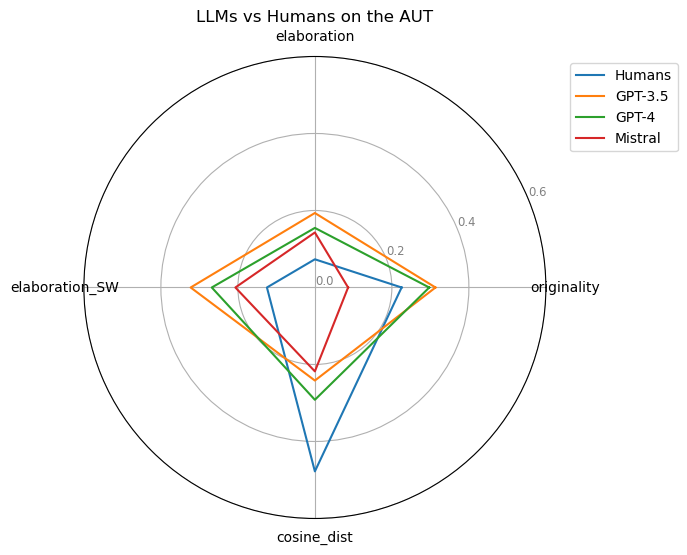

In [112]:
features = ['prompt', 'originality', 'elaboration', 'elaboration_SW', 'cosine_dist']

humans_norm = combined_data_norm[combined_data_norm['dataset'] == 'Humans']
gpt_35_norm = combined_data_norm[combined_data_norm['dataset'] == 'GPT-3.5']
gpt_4_norm = combined_data_norm[combined_data_norm['dataset'] == 'GPT-4']
mistral_norm = combined_data_norm[combined_data_norm['dataset'] == 'Mistral']

# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm[features], gpt_4_norm[features], mistral_norm[features]]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral']

# Plot radar chart for multiple dataframes
plot_radar_chart(dataframes, titles, avg_per_object = True)

# Radar charts per model

Question: 
- Are humans and LLMs more creative depending on the object ? What similarities and differences do they have ?
- Given a model, does the model performs differently depending on the object? And how ? (along which dimensions ?)

In [9]:
# normalize for each model across all objects
features = ["originality", "elaboration", "elaboration_SW", "cosine_dist"]

humans_norm = normalization_per_model(humans)
gpt_35_norm = normalization_per_model(gpt_35_100)
gpt_4_norm = normalization_per_model(gpt_4_100)
mistral_norm = normalization_per_model(mistral)

# List of dataframes and corresponding titles
dataframes = [humans_norm[features], gpt_35_norm[features], gpt_4_norm[features], mistral_norm[features]]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral']

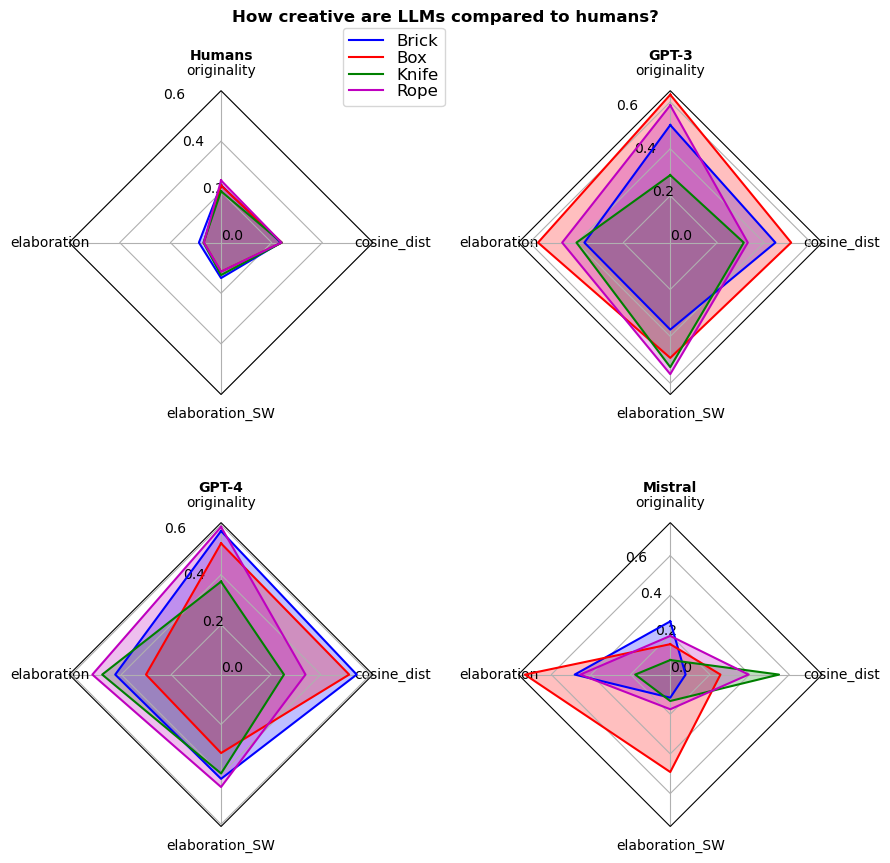

In [10]:
# dimensions to plot
features_to_plot = ["originality", "elaboration", "elaboration_SW", "cosine_dist"]
#features_to_plot = ["originality", "elaboration", "elaboration_SW"]

radar_charts_per_model(humans_norm, gpt_35_norm, gpt_4_norm, mistral_norm, features_to_plot)

# Radar charts per object

Question: Given an object, how are humans and LLMs performing ? Is it different and how ? (along which dimensions ?)

In [11]:
# combine the data for each object and normalize across all models

brick_data = pd.concat([
    humans[humans['prompt'] == 'brick'].assign(dataset='Humans'),
    gpt_35_100[gpt_35_100['prompt'] == 'brick'].assign(dataset='GPT-3.5'),
    gpt_4_100[gpt_4_100['prompt'] == 'brick'].assign(dataset='GPT-4'),
    mistral[mistral['prompt'] == 'brick'].assign(dataset='Mistral')
])
box_data = pd.concat([
    humans[humans['prompt'] == 'box'].assign(dataset='Humans'),
    gpt_35_100[gpt_35_100['prompt'] == 'box'].assign(dataset='GPT-3.5'),
    gpt_4_100[gpt_4_100['prompt'] == 'box'].assign(dataset='GPT-4'),
    mistral[mistral['prompt'] == 'box'].assign(dataset='Mistral')
])
knife_data = pd.concat([
    humans[humans['prompt'] == 'knife'].assign(dataset='Humans'),
    gpt_35_100[gpt_35_100['prompt'] == 'knife'].assign(dataset='GPT-3.5'),
    gpt_4_100[gpt_4_100['prompt'] == 'knife'].assign(dataset='GPT-4'),
    mistral[mistral['prompt'] == 'knife'].assign(dataset='Mistral')
])
rope_data = pd.concat([
    humans[humans['prompt'] == 'rope'].assign(dataset='Humans'),
    gpt_35_100[gpt_35_100['prompt'] == 'rope'].assign(dataset='GPT-3.5'),
    gpt_4_100[gpt_4_100['prompt'] == 'rope'].assign(dataset='GPT-4'),
    mistral[mistral['prompt'] == 'rope'].assign(dataset='Mistral')
])

brick_norm = normalization_1(brick_data, check_norm = False)
box_norm = normalization_1(box_data, check_norm = False)
knife_norm = normalization_1(knife_data, check_norm = False)
rope_norm = normalization_1(rope_data, check_norm = False)

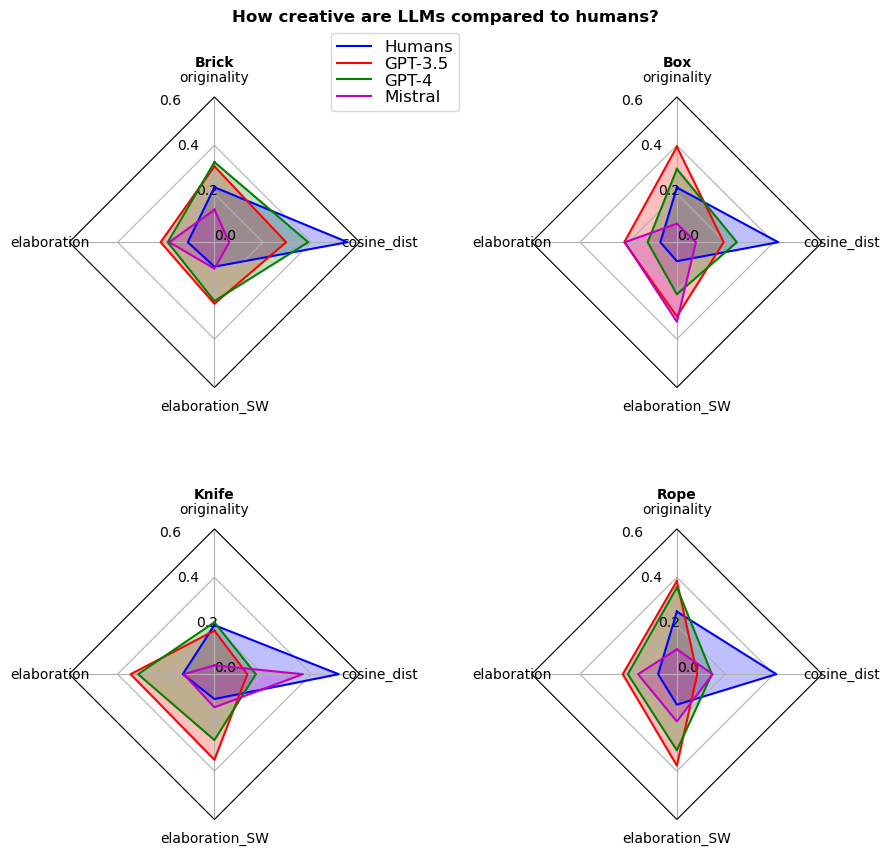

In [12]:
# List of dataframes and corresponding titles
features = ["originality", "elaboration", "elaboration_SW", "cosine_dist"]
dataframes = [brick_norm, box_norm, knife_norm, rope_norm]
titles = ['Humans', 'GPT-3.5', 'GPT-4', 'Mistral']

radar_charts_per_object(brick_norm, box_norm, knife_norm, rope_norm, features)

#